In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from metrics.internal_metrics import compute_all_metrics

In [3]:
data = pd.read_csv('../dataset/Dortmund_features_preprocessed.csv', index_col=0)
features = data.values
subject_ids = data.index.values

print(f"Data shape: {features.shape}")
print(f"Number of subjects: {len(subject_ids)}")
print(f"Number of features: {features.shape[1]}")

Data shape: (600, 100)
Number of subjects: 600
Number of features: 100


In [4]:
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(features)

labels = clustering.labels_ #-1 = noise

In [5]:
unique_labels = set(labels)
n_noise = list(labels).count(-1)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

print(f"Numero di cluster trovati (escluso noise): {n_clusters}")
print(f"Numero di punti marcati come noise: {n_noise}")


Numero di cluster trovati (escluso noise): 1
Numero di punti marcati come noise: 0


In [6]:
mask_inliers = labels != -1
features_inliers = features[mask_inliers]
labels_inliers = labels[mask_inliers]

metrics_optics = compute_all_metrics(features_inliers, labels_inliers, include_dunn=False)

print(f"Silhouette (solo inliers): {metrics_optics['silhouette_score']:.4f}")
print(f"Davies-Bouldin (solo inliers): {metrics_optics['davies_bouldin_score']:.4f}")
print(f"Calinski-Harabasz (solo inliers): {metrics_optics['calinski_harabasz_score']:.2f}")

Silhouette (solo inliers): nan
Davies-Bouldin (solo inliers): nan
Calinski-Harabasz (solo inliers): nan


## Testing OPTICS with different minimum sample sizes

Testing different min_samples values with OPTICS...
min_samples=3: clusters=2, noise=526, Silhouette=0.3224, Davies-Bouldin=1.2612, Calinski-Harabasz=41.70
min_samples=5: clusters=2, noise=518, Silhouette=0.3690, Davies-Bouldin=1.1198, Calinski-Harabasz=60.93
min_samples=7: clusters=3, noise=491, Silhouette=0.2501, Davies-Bouldin=1.5394, Calinski-Harabasz=44.87
min_samples=10: clusters=2, noise=496, Silhouette=0.3301, Davies-Bouldin=1.2588, Calinski-Harabasz=59.64


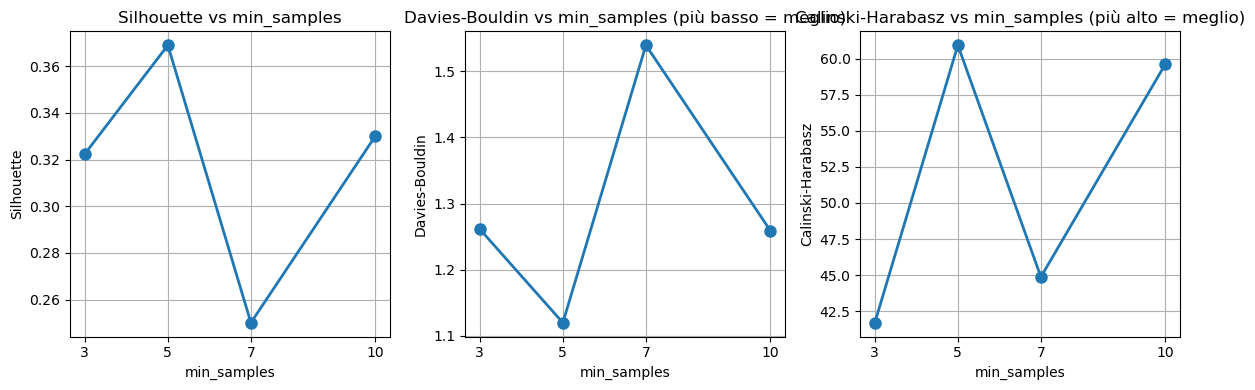

In [7]:
# Testing different min_samples values, the one yielding best metrics is min_samples_values = 5
min_samples_values = [3, 5, 7, 10]
results_ms = {}

print("Testing different min_samples values with OPTICS...")
for ms in min_samples_values:
    clustering = OPTICS(
        min_samples=ms,
        xi=0.01, # more sensible to changes in density in the reachability plot
        min_cluster_size=0.05,
        metric = "cosine"
    )
    clustering.fit(features)
    labels = clustering.labels_

    # Escludi noise per le metriche
    mask_inliers = labels != -1
    features_inliers = features[mask_inliers]
    labels_inliers = labels[mask_inliers]

    if len(set(labels_inliers)) < 2:
        print(f"min_samples={ms}: meno di 2 cluster tra gli inliers, salto metriche.")
        continue

    metrics_ms = compute_all_metrics(features_inliers, labels_inliers, include_dunn=False)

    unique_labels = set(labels)
    n_noise = list(labels).count(-1)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    results_ms[ms] = {
        'clustering': clustering,
        'labels': labels,
        'metrics': metrics_ms,
        'n_clusters': n_clusters,
        'n_noise': n_noise
    }

    print(f"min_samples={ms}: "
          f"clusters={n_clusters}, noise={n_noise}, "
          f"Silhouette={metrics_ms['silhouette_score']:.4f}, "
          f"Davies-Bouldin={metrics_ms['davies_bouldin_score']:.4f}, "
          f"Calinski-Harabasz={metrics_ms['calinski_harabasz_score']:.2f}")

# ====== PLOT delle metriche in funzione di min_samples ======
plt.figure(figsize=(12, 4))

# 1) Silhouette
plt.subplot(1, 3, 1)
silhouettes = [results_ms[ms]['metrics']['silhouette_score'] for ms in results_ms.keys()]
plt.plot(list(results_ms.keys()), silhouettes, 'o-', linewidth=2, markersize=8)
plt.xlabel('min_samples')
plt.ylabel('Silhouette')
plt.title('Silhouette vs min_samples')
plt.grid(True)
plt.xticks(list(results_ms.keys()))

# 2) Davies-Bouldin
plt.subplot(1, 3, 2)
db_scores = [results_ms[ms]['metrics']['davies_bouldin_score'] for ms in results_ms.keys()]
plt.plot(list(results_ms.keys()), db_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('min_samples')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin vs min_samples (più basso = meglio)')
plt.grid(True)
plt.xticks(list(results_ms.keys()))

# 3) Calinski-Harabasz
plt.subplot(1, 3, 3)
ch_scores = [results_ms[ms]['metrics']['calinski_harabasz_score'] for ms in results_ms.keys()]
plt.plot(list(results_ms.keys()), ch_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('min_samples')
plt.ylabel('Calinski-Harabasz')
plt.title('Calinski-Harabasz vs min_samples (più alto = meglio)')
plt.grid(True)
plt.xticks(list(results_ms.keys()))

plt.tight_layout()
plt.show()


## Testing different min_cluster_size values and xi, keeping min_samples

Testing different (xi, min_cluster_size) combinations with OPTICS...
xi=0.005, min_cluster_size=0.010 --> clusters=12, noise=496, Silhouette=0.1542, DB=1.6440, CH=15.62
xi=0.005, min_cluster_size=0.020 --> clusters=5, noise=527, Silhouette=0.2495, DB=1.4102, CH=25.12
xi=0.005, min_cluster_size=0.050 --> clusters=3, noise=485, Silhouette=0.2581, DB=1.5540, CH=41.76
xi=0.005, min_cluster_size=0.100 --> clusters=2, noise=464, Silhouette=0.2751, DB=1.4752, CH=57.21
xi=0.010, min_cluster_size=0.010 --> clusters=11, noise=504, Silhouette=0.1734, DB=1.5737, CH=15.66
xi=0.010, min_cluster_size=0.020 --> clusters=4, noise=540, Silhouette=0.2634, DB=1.4388, CH=29.27
xi=0.010, min_cluster_size=0.050 --> clusters=2, noise=518, Silhouette=0.3690, DB=1.1198, CH=60.93
xi=0.010, min_cluster_size=0.100 --> clusters=1, noise=536, Silhouette=nan, DB=nan, CH=nan
xi=0.020, min_cluster_size=0.010 --> clusters=7, noise=544, Silhouette=0.2399, DB=1.3103, CH=16.66
xi=0.020, min_cluster_size=0.020 --> clusters=

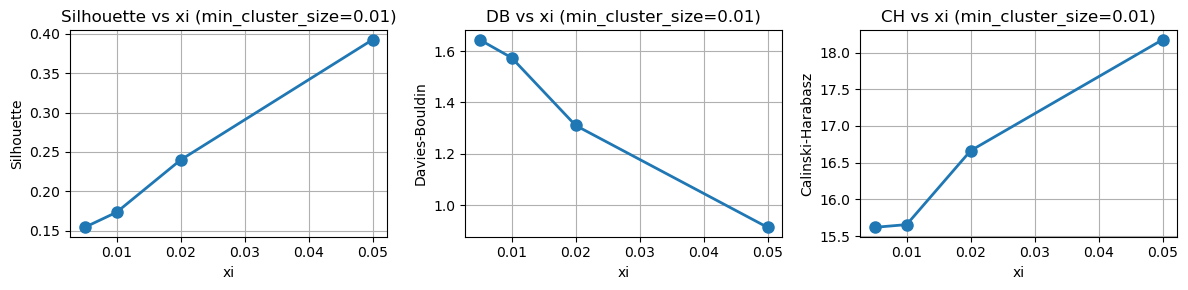

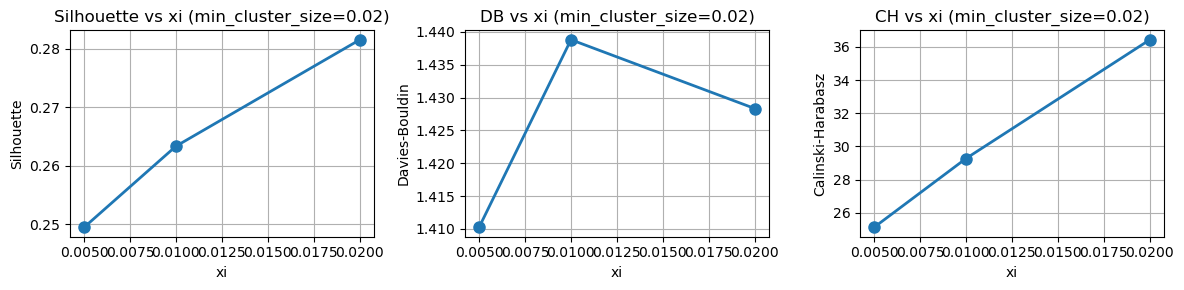

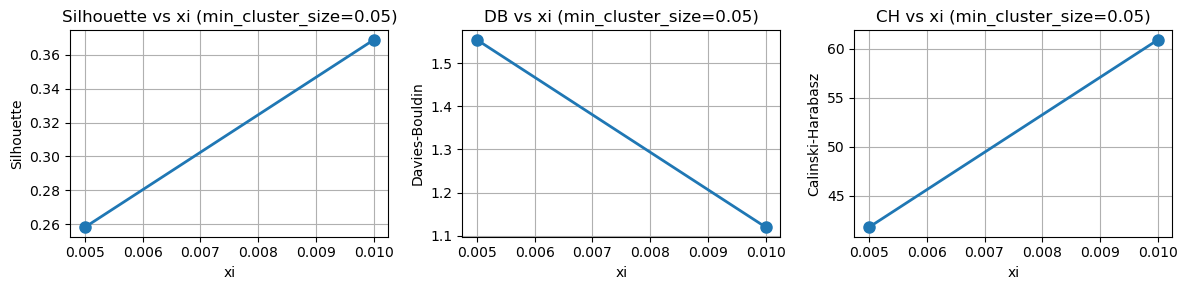

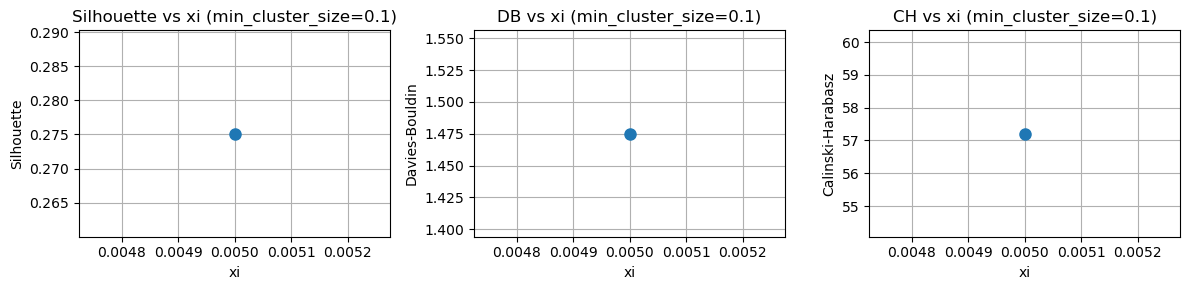

In [8]:
from sklearn.cluster import OPTICS
import numpy as np
import matplotlib.pyplot as plt

# Your data matrix
# features = X_clean.values  # for example

min_samples = 5  # keep fixed for now, since this seems to work
xi_values = [0.005, 0.01, 0.02, 0.05]
min_cluster_size_values = [0.01, 0.02, 0.05, 0.1]  # as fractions of n_samples

results = {}

print("Testing different (xi, min_cluster_size) combinations with OPTICS...")
for xi in xi_values:
    for mcs in min_cluster_size_values:
        clustering = OPTICS(
            min_samples=min_samples,
            xi=xi,
            min_cluster_size=mcs,
            metric="cosine"
        )
        clustering.fit(features)
        labels = clustering.labels_

        unique_labels = set(labels)
        n_noise = list(labels).count(-1)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        # Prepare key for this combination
        key = (xi, mcs)

        # Compute metrics only if we have at least 2 clusters among non-noise points
        mask_inliers = labels != -1
        features_inliers = features[mask_inliers]
        labels_inliers = labels[mask_inliers]

        if len(set(labels_inliers)) >= 2:
            metrics = compute_all_metrics(features_inliers, labels_inliers, include_dunn=False)
            sil = metrics['silhouette_score']
            db = metrics['davies_bouldin_score']
            ch = metrics['calinski_harabasz_score']
        else:
            sil, db, ch = np.nan, np.nan, np.nan

        results[key] = {
            'clustering': clustering,
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil,
            'davies_bouldin': db,
            'calinski_harabasz': ch
        }

        print(f"xi={xi:.3f}, min_cluster_size={mcs:.3f} --> "
              f"clusters={n_clusters}, noise={n_noise}, "
              f"Silhouette={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")

# ---- Optional: visualize how metrics change with xi for each min_cluster_size ----
# (you can comment this block out if you don’t need plots)

for mcs in min_cluster_size_values:
    # Filter results for this min_cluster_size
    xis = []
    sils = []
    dbs = []
    chs = []

    for xi in xi_values:
        key = (xi, mcs)
        if key in results:
            xis.append(xi)
            sils.append(results[key]['silhouette'])
            dbs.append(results[key]['davies_bouldin'])
            chs.append(results[key]['calinski_harabasz'])

    plt.figure(figsize=(12, 3))

    # 1) Silhouette
    plt.subplot(1, 3, 1)
    plt.plot(xis, sils, 'o-', linewidth=2, markersize=8)
    plt.xlabel('xi')
    plt.ylabel('Silhouette')
    plt.title(f'Silhouette vs xi (min_cluster_size={mcs})')
    plt.grid(True)

 
    # 2) Davies-Bouldin
    plt.subplot(1, 3, 2)
    plt.plot(xis, dbs, 'o-', linewidth=2, markersize=8)
    plt.xlabel('xi')
    plt.ylabel('Davies-Bouldin')
    plt.title(f'DB vs xi (min_cluster_size={mcs})')
    plt.grid(True)

    # 3) Calinski-Harabasz
    plt.subplot(1, 3, 3)
    plt.plot(xis, chs, 'o-', linewidth=2, markersize=8)
    plt.xlabel('xi')
    plt.ylabel('Calinski-Harabasz')
    plt.title(f'CH vs xi (min_cluster_size={mcs})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
